In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.8 MB/s eta 0:00:00


In [ ]:
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import cv2 as cv

Aqui carregamos o modelos do YOLO que iremos usar. Nesse caso como a qualidade da camera de segurança não é satisfatoria optou-se por usar o Yolo 11 Small, superior ao Yolo 11 Nano.

# Teste Inicial

In [13]:
model = YOLO('yolo11s.pt')
CONF_THR = 0.5

classes_desejadas = [0] #[0, 1, 2, 3, 4]

#   "0": "person",
#   "1": "bicycle",
#   "2": "car",

def retirar_ruidos_frame(frame):
    frame = cv.medianBlur(frame, 3)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame = cv.equalizeHist(frame)
    frame = cv.cvtColor(frame, cv.COLOR_GRAY2BGR)
    return frame

def coordenadas_da_deteccao(results):
  if results[0].boxes is not None:
    for i, box in enumerate(results[0].boxes):
        # Coordenadas da bounding box (x1, y1, x2, y2)
        coords = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = coords.astype(int)

        # Confiança
        conf = box.conf[0].cpu().numpy()

        # Classe
        cls = int(box.cls[0].cpu().numpy())

        # Calcular centro e dimensões
        centro_x = int((x1 + x2) / 2)
        centro_y = int((y1 + y2) / 2)



        #print(f"  Classe: {cls}")
        print(f"  Confiança: {conf:.3f}")
        print(f"  Coordenadas (x1, y1, x2, y2): ({x1}, {y1}, {x2}, {y2})")
        print(f"  Centro: ({centro_x}, {centro_y})")
        print("-" * 40)
  else:
      print("Nenhuma detecção encontrada!")


0: 384x640 1 person, 354.1ms
Speed: 4.7ms preprocess, 354.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
  Confiança: 0.682
  Coordenadas (x1, y1, x2, y2): (448, 255, 590, 661)
  Centro: (519, 458)
----------------------------------------


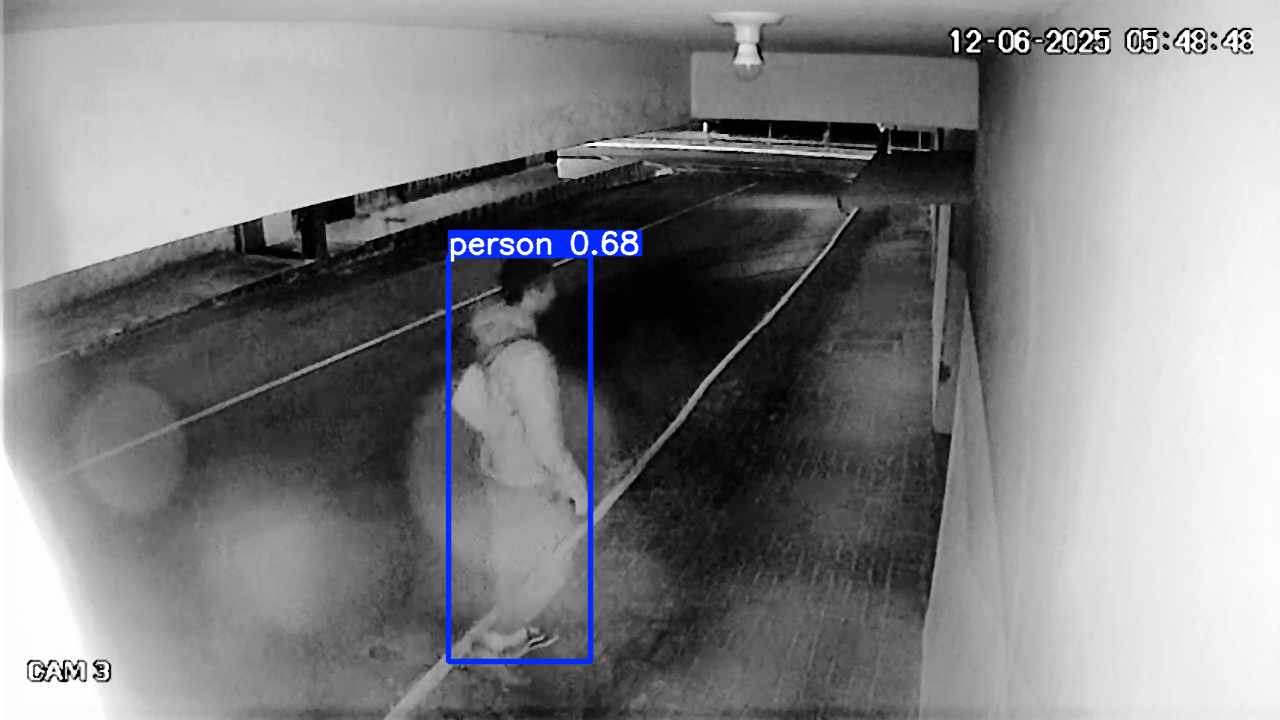

In [14]:
imagem = cv.imread('arthur_garagem - frame at 0m18s.jpg')
imagem_equalizada = retirar_ruidos_frame(imagem)

results = model.predict(
    source=imagem_equalizada,
    classes=classes_desejadas,
    conf=CONF_THR,
    stream=False,
    verbose=True
)

coordenadas_da_deteccao(results)

frame_com_predicoes = results[0].plot()



#cv.imshow('Imagem Original', imagem)
#cv.imshow('Imagem Equalizada', imagem_equalizada)
cv2_imshow(frame_com_predicoes)




# Função para detecção

In [17]:
import cv2 as cv
from ultralytics import YOLO
import numpy as np
from typing import List, Dict, Tuple, Optional

# Inicialização do modelo (fazer apenas uma vez)
model = YOLO('yolo11s.pt')
CONF_THR = 0.5
classes_desejadas = [0]  # [0, 1, 2, 3, 4]
#   "0": "person",
#   "1": "bicycle",
#   "2": "car",

def retirar_ruidos_frame(frame: np.ndarray) -> np.ndarray:
    """Remove ruídos do frame aplicando filtros."""
    frame = cv.medianBlur(frame, 3)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame = cv.equalizeHist(frame)
    frame = cv.cvtColor(frame, cv.COLOR_GRAY2BGR)
    return frame

def extrair_coordenadas_deteccao(results) -> List[Dict]:
    """Extrai coordenadas e informações das detecções."""
    deteccoes = []

    if results[0].boxes is not None:
        for i, box in enumerate(results[0].boxes):
            # Coordenadas da bounding box (x1, y1, x2, y2)
            coords = box.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = coords.astype(int)

            # Confiança
            conf = float(box.conf[0].cpu().numpy())

            # Classe
            cls = int(box.cls[0].cpu().numpy())

            # Calcular centro
            centro_x = int((x1 + x2) / 2)
            centro_y = int((y1 + y2) / 2)

            deteccao = {
                'id': i + 1,
                'classe': cls,
                'confianca': conf,
                'bbox': (x1, y1, x2, y2),
                'centro': (centro_x, centro_y),
                'largura': x2 - x1,
                'altura': y2 - y1
            }

            deteccoes.append(deteccao)

    return deteccoes

def detectar_objetos(frame: np.ndarray,
                    processar_frame: bool = True,
                    verbose: bool = False,
                    retornar_frame_anotado: bool = False) -> Dict:
    """
    Detecta objetos no frame usando YOLO.

    Args:
        frame: Frame de entrada (numpy array)
        processar_frame: Se deve aplicar pré-processamento no frame
        verbose: Se deve imprimir informações das detecções
        retornar_frame_anotado: Se deve retornar o frame com anotações

    Returns:
        Dict contendo:
        - 'deteccoes': Lista com informações das detecções
        - 'frame_anotado': Frame com bounding boxes (se solicitado)
        - 'total_deteccoes': Número total de detecções
    """
    try:
        # Pré-processamento opcional
        if processar_frame:
            frame_processado = retirar_ruidos_frame(frame)
        else:
            frame_processado = frame

        # Predição
        results = model.predict(
            source=frame_processado,
            classes=classes_desejadas,
            conf=CONF_THR,
            stream=False,
            verbose=False  # Sempre False para não travar
        )

        # Extrair coordenadas
        deteccoes = extrair_coordenadas_deteccao(results)

        # Print opcional das informações
        if verbose and deteccoes:
            print(f"=== {len(deteccoes)} DETECÇÃO(ÕES) ENCONTRADA(S) ===")
            for det in deteccoes:
                print(f"  Classe: {det['classe']}")
                print(f"  Confiança: {det['confianca']:.3f}")
                print(f"  Coordenadas: {det['bbox']}")
                print(f"  Centro: {det['centro']}")
                print("-" * 40)
        elif verbose:
            print("Nenhuma detecção encontrada!")


        resultado = {
            'deteccoes': deteccoes,
            'total_deteccoes': len(deteccoes),
            'sucesso': True
        }

        # Frame anotado opcional
        if retornar_frame_anotado:
            resultado['frame_anotado'] = results[0].plot()

        return resultado

    except Exception as e:
        print(f"Erro na detecção: {str(e)}")
        return {
            'deteccoes': [],
            'total_deteccoes': 0,
            'sucesso': False,
            'erro': str(e)
        }



=== 1 DETECÇÃO(ÕES) ENCONTRADA(S) ===
  Classe: 0
  Confiança: 0.682
  Coordenadas: (np.int64(448), np.int64(255), np.int64(590), np.int64(661))
  Centro: (519, 458)
----------------------------------------

Detecções realizadas com sucesso!
Total de detecções: 1


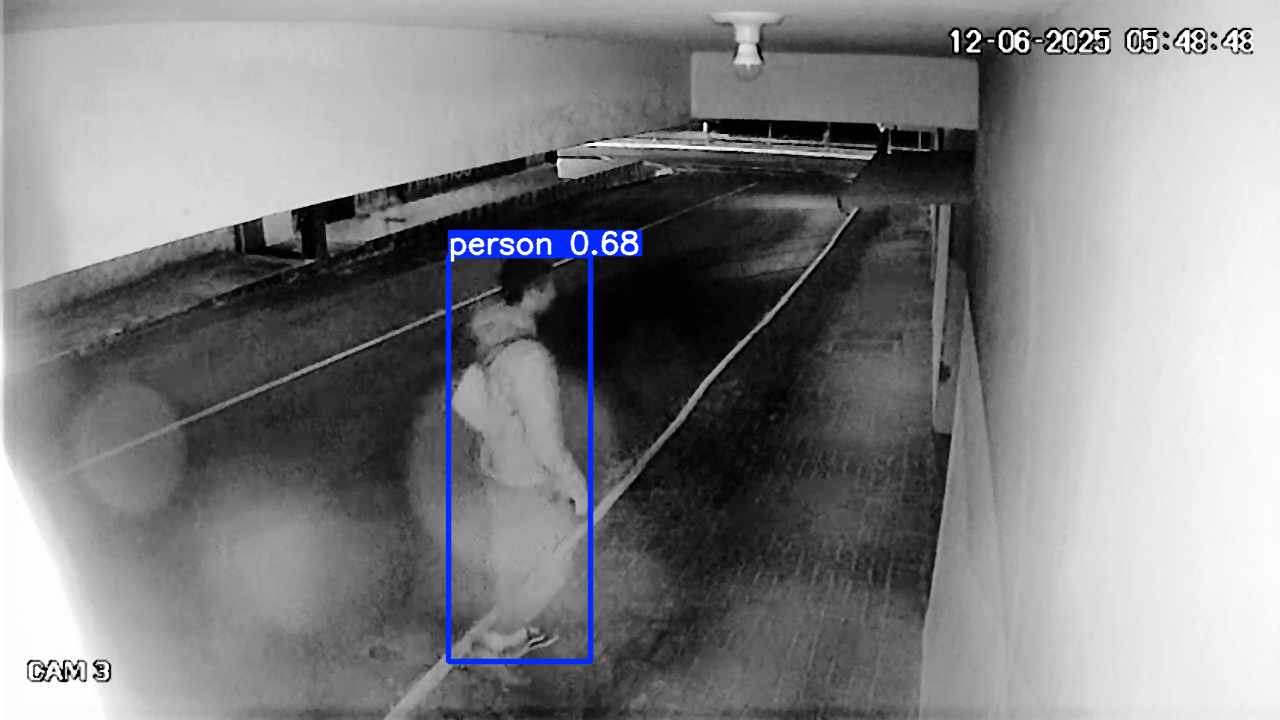

In [18]:
# teste do sistema
if __name__ == "__main__":
    imagem = cv.imread('arthur_garagem - frame at 0m18s.jpg')

    if imagem is not None:
        resultado = detectar_objetos(
            frame=imagem,
            processar_frame=True,
            verbose=True,
            retornar_frame_anotado=True
        )


        if resultado['sucesso']:
            print(f"\nDetecções realizadas com sucesso!")
            print(f"Total de detecções: {resultado['total_deteccoes']}")

            if 'frame_anotado' in resultado:

                # Para Colab:
                from google.colab.patches import cv2_imshow
                cv2_imshow(resultado['frame_anotado'])

                # Para ambiente local:
                #cv.imshow('Detecções', resultado['frame_anotado'])
                #cv.waitKey(0)
                #cv.destroyAllWindows()
        else:
            print(f"Erro na detecção: {resultado.get('erro', 'Erro desconhecido')}")
    else:
        print("Erro ao carregar a imagem!")